# Cross-Validation of your models

One of the things about machine learning is that it often leverages randomness (sampling, shuffling, etc) to build the strength in your claims. We can use this to our advantage by being able to estimate the performance of model. Below we show how to do this using "Monte Carlo" methods, i.e., simple bootstrapping.

The `sci-kit` library has many buiult-in tools for validation, which you will emply at the end on your own.

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#conda install -c conda-forge seaborn (you might need to run this first)
import seaborn as sns

## Generate some regression data and store it in a data frame

In [2]:
# Generate regression dataset with 10 variables
X, y = make_regression(n_samples=1000, n_features=20, n_informative=3, noise=10)


# Convert the data set to a Pandas dataframe
df = pd.DataFrame(X)
df['response'] = y

## Plot the features

**Note this takes a while to run. You don't have to use it everytime**

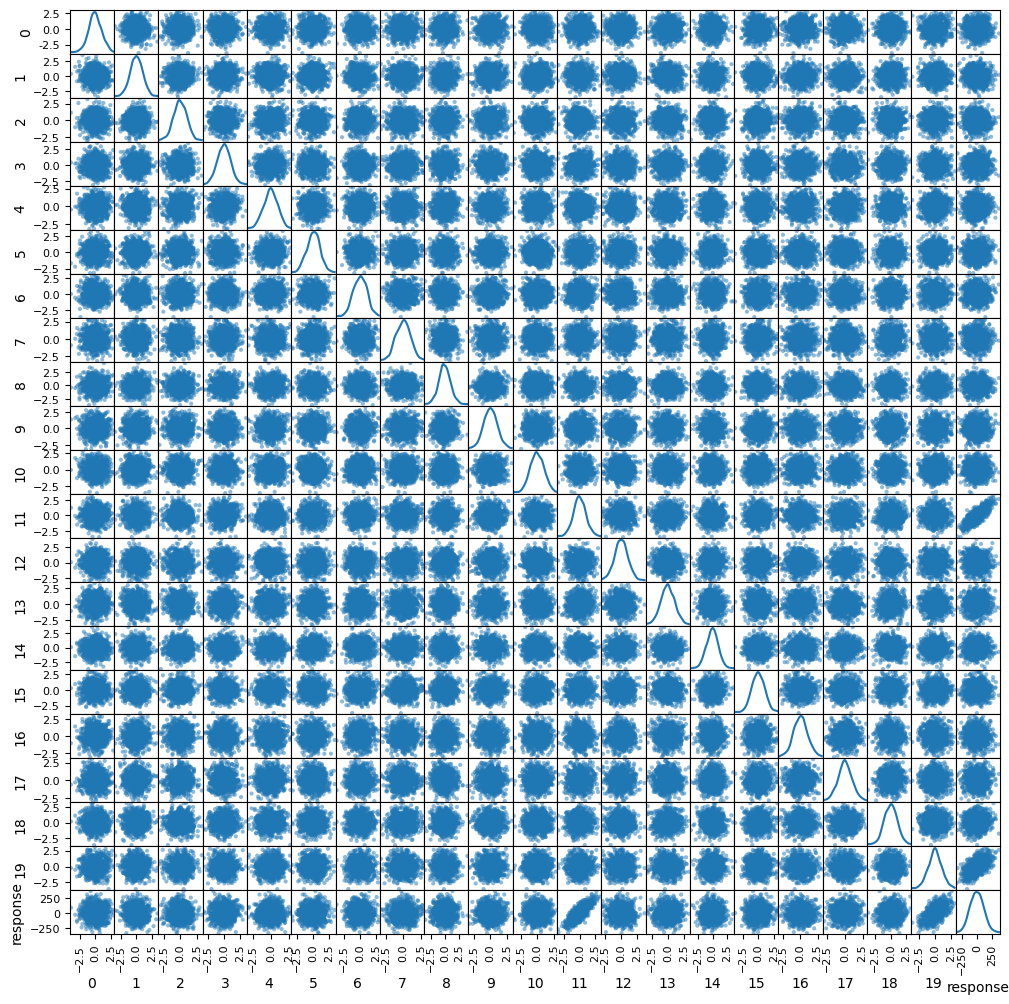

In [3]:
# Create a scatter plot of the features
pd.plotting.scatter_matrix(df, figsize=(12,12), diagonal='kde')
plt.show()

## Make our process modular

One of the useful things about the `sci-kit` library is that it makes the process of doing machine learning pretty routine. In that we know the process that we follow and we can find where in the process to diagnose issues. This is not to say any of this is simple, but rather it can be made into a process.

Below, we've written a function that performs a linear regression on data. It returns the Mean Sqaured Error (`mse`), the R$^2$ value (`r2`), and the fit coefficients for the linear model (`coeffs`). Notice this last variable is a list not just a number. It will be as long as the number of features in the model.

In [4]:
def linear_regression(X, y, testSize=0.2):
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize)

    # Create a linear regression model
    lr = LinearRegression()

    # Fit the model with the training data
    lr.fit(X_train, y_train)

    # Predict the target variable using the test data
    y_pred = lr.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = lr.score(X_test, y_test)
    coeffs = lr.coef_

    return mse, r2, coeffs

### Call our function

Now, we can call our function a notice that it produces a differnt value each time because it is randomly sampling every time it runs.

In [5]:
mse, r2, coeffs = linear_regression(X,y)
print('MSE: ', mse)
print('R2: ', r2)
print('Fit Coefficients:\n', coeffs)

MSE:  98.96798167498
R2:  0.9930096640657938
Fit Coefficients:
 [-3.21513642e-02 -7.55686973e-01 -4.58538664e-01 -2.70573959e-01
 -3.28202788e-01  4.13940126e-01  6.51068851e-01  4.20486983e-01
  1.14324548e-01 -4.50924635e-01  5.16797589e-03  8.49830953e+01
  2.84563562e-01  2.52898167e-03 -5.68216789e-01 -2.37279423e-01
  1.11208919e+00 -1.34804376e-01  6.14012296e+00  6.27498050e+01]


In [6]:
mse, r2, coeffs = linear_regression(X,y)
print('MSE: ', mse)
print('R2: ', r2)
print('Fit Coefficients:\n', coeffs)

MSE:  103.41229981688804
R2:  0.9907742562674412
Fit Coefficients:
 [-5.65149720e-02 -4.70240888e-01 -2.27115465e-01 -4.92981978e-02
 -1.76110515e-01  5.79279059e-01  2.23285151e-01  2.54987117e-01
  1.27265084e-01 -7.31601076e-01 -1.21415706e-01  8.51852339e+01
  1.43907420e-02 -9.53065647e-02 -7.92060421e-01 -1.42089017e-01
  1.20383133e+00 -1.19166306e-01  5.84018326e+00  6.23724831e+01]


## Automating the runs

Now that we have this working, we can run a loop a perform as many of these analyses as we like. Below, we've written a short loop that does this and stores all the important things a pandas data frame for later.

In [7]:
Nruns = 100
arr = np.arange(1,Nruns+1)

# Initialize an empty list to store the DataFrame of each run
dfs = []

for i in arr:

    # Run the linear regression function
    mse, r2, coeffs = linear_regression(X, y)

    # Create a DataFrame for this run
    df = pd.DataFrame({'Run': i, 'MSE': mse, 'R2': r2, 'Coeffs': [coeffs]})

    # Append the DataFrame to the list of all runs
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
results_df = pd.concat(dfs, ignore_index=True)

# Print the results DataFrame
#print(results_df)

### Plot the distributions

Below, we plot the distributions of the results, which demonstrate both the random nature of the train/test splitting, but also that we can build confidence in our analysis by providing uncertainty to our estimates.

In [8]:
### Plotting MSE and R2

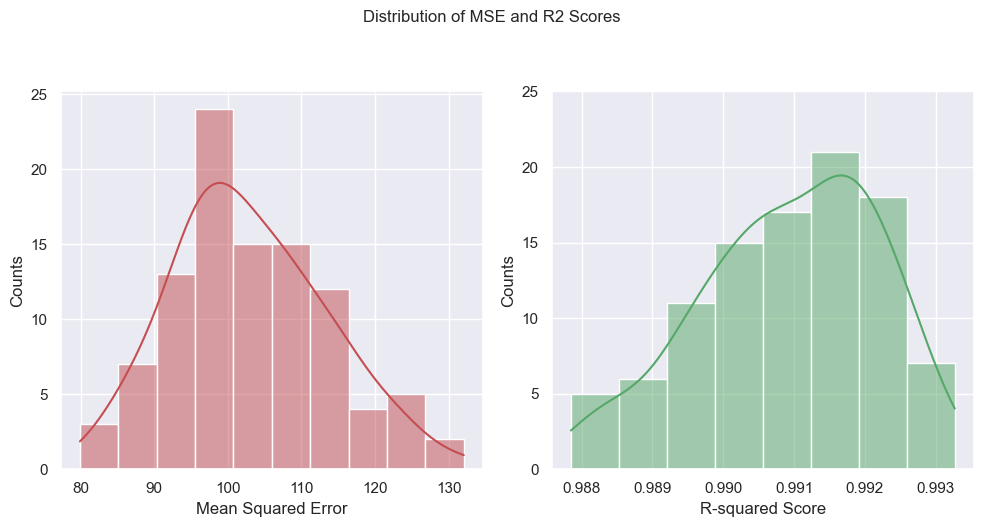

In [9]:
sns.set(style='darkgrid')

# Plot a pair of histograms for the MSE and R2 scores
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(results_df['MSE'], ax=ax[0], kde=True, color='r', edgecolor='w')
sns.histplot(results_df['R2'], ax=ax[1], kde=True, color='g', edgecolor='w')

# Set the axis labels and titles
ax[0].set_xlabel('Mean Squared Error')
ax[1].set_xlabel('R-squared Score')
ax[0].set_ylabel('Counts')
ax[1].set_ylabel('Counts')

# Change the y-tick marks
yticks = [0, 5, 10, 15, 20, 25]
ax[0].set_yticks(yticks)
ax[1].set_yticks(yticks)

plt.suptitle('Distribution of MSE and R2 Scores', fontsize=12, y=1.05)

plt.tight_layout()
plt.show()

In [10]:
### Plotting Fit Coefficients

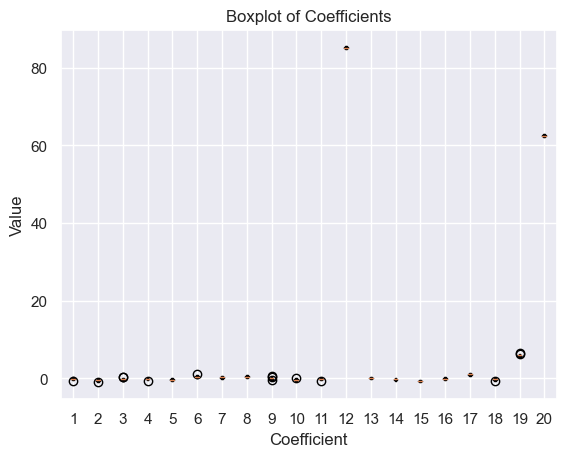

In [11]:
coeffs_data = []

for run in results_df['Coeffs']:
    coeffs_data.append(run)

num_coeffs = len(coeffs_data[0])
positions = range(1, num_coeffs + 1)

for i in range(num_coeffs):
    # Extract coefficients
    coefficient_data = []
    for run in coeffs_data:
        coefficient_data.append(run[i])
    # Create boxplot
    plt.boxplot(coefficient_data, positions=[positions[i]])
    
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.title('Boxplot of Coefficients')
plt.xticks(positions, range(1, num_coeffs + 1))
plt.show()

## Things to try

We have performed "Monte Carlo" validation where we randomly sample the training and test sets. The `sci-kit` library has forms of validation built-in. You can find lots of [details on their documentation](https://scikit-learn.org/stable/modules/cross_validation.html). Here's a bit more on how each validator [selects data](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).

* Review the `sci-kit` documentation and reproduce our work above using a built-in validator.
* Change the training and testing sizes, how well does your model perform?